In [1]:
### import de librairies utiles
from __future__ import division
import numpy as np
import scipy.fftpack as sf
import matplotlib.pyplot as plt
import pylab as pl
import scipy.signal as sig
from scipy import misc
from IPython.display import Audio

In [35]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

## 1. STFT  (Short Time Fourier Transform) et séparation de source.

## Dans cette partie, on utilise la STFT qui est une collection de transformées de Fourier d'un signal 1D sur des sous-intervals temporels. Pourquoi utiliser la STFT?
- La longueur du signal musical échantillonné à une fréquence de 44kHz et qui a une longueur temporelle de 4 minutes est de l'ordre de $4*60*44000 \simeq 1.1 \times 10^7$.
- La longueur d'une note de musique (disons d'un son dont la note est reconnaissable) est de l'ordre de quelques dixièmes de seconde. 
### Conclusion: On n'utilise pas la FFT sur tout le signal mais sur des sous-parties du signals qui sont de longueur plus courte, d'un ordre fixé.

### On l'utilise pour expérimenter l'idée de séparer des sources sonores qui sont superposées. L'idée est que des signaux différents, par exemple, une personne qui parle et un morceaux de piano présentent des spectres très différents, et que cette différence peut être utilisée pour isoler les signaux.

In [31]:
# utils to load the sounds.
import wave as wv

def load_sound(file, n0):
    """
    file: nom du fichier
    n0: taille de l'échantillon à conserver
    """
    
    x_raw = wv.open(file)
    n = x_raw.getnframes()
    x = np.frombuffer(x_raw.readframes(-1), 'Int16')
    x_raw.close()
    
    if file == "bird.wav":
        x = np.delete(x,list(range(6001)) + list(range(12500, 15001)) + list(range(22500, 24001)) + list(range(32500,34001)))

    if n0 !=0 and n0 < n:
        x = x[:n0]
    
    return x/np.max(x) # on normalise toutes les intensités sonores au même niveau

## Dans l'exemple ci-dessous, on charge trois sons différents et on les trace.

In [32]:
for file in ["bird.wav","female.wav","male.wav"]:
    x_raw = wv.open(file)
    print(x_raw.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=107895, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=160000, comptype='NONE', compname='not compressed')
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=160000, comptype='NONE', compname='not compressed')


In [33]:
n = 16000 # nombre de point à conserver dans chacun des enregistrements

x = np.zeros([n,3])
x[:,0] = load_sound("bird.wav",n)
x[:,1] = load_sound("female.wav",n)
x[:,2] = load_sound("male.wav",n)

# On écoute le signal sonore 0 par exemple
Audio(x[:,0], rate = 16000)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  if sys.path[0] == '':


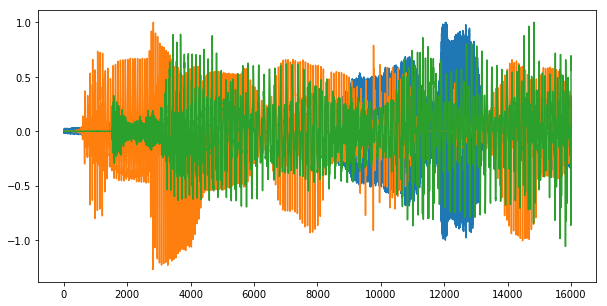

In [34]:
# le signal reçu semble temporellement indiscernable
plt.figure(figsize = (10,5))
plt.plot(x)
plt.show()

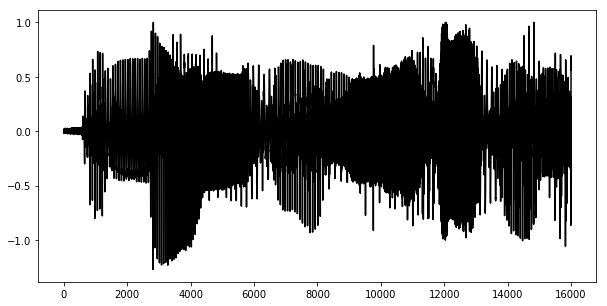

In [7]:
# sans couleur pour distinguer les différentes sources c'est encore plus clair
plt.figure(figsize = (10,5))
plt.plot(x, color='black')
plt.show()

### On utilise la fonction STFT du package python signal et on les trace comme une image 2D. 

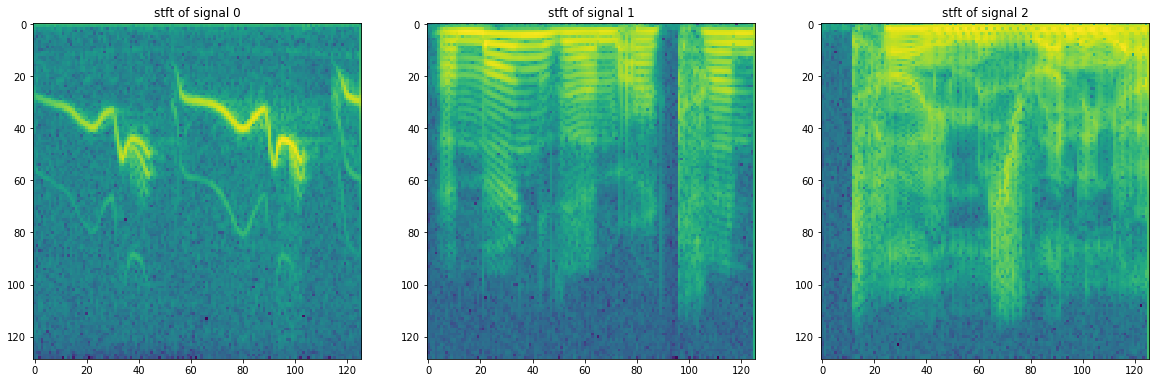

In [8]:
plt.figure(figsize = (20,10))
for i in range(3):
    f,t,w = sig.stft(x[:,i])
    plt.subplot(1,3,i+1)
    plt.title("stft of signal %s" % i)
    plt.imshow(np.log(np.abs(w))) 

### Q: Trouver dans la documentation de la fonction tdtf du package scipy le paramètre qui contrôle la taille de la fenetre temporelle dans l'algorithme de stfd, et afficher les graphes 2D correspondant. Les interpréter. 

In [9]:
### Écrivez votre code ici.

### On vérifie numériquement que les fonctions STFT et ISTFT sont bien inverses numériques l'une de l'autre. 

In [10]:
t,f,z = sig.stft(x[:,0])
t, x0_recovered = sig.istft(z)
np.sum((x0_recovered - x[:,0])**2)

4.1416950074764037e-29

### Pour avoir plus d'information qu'un seul micro, ce qui donnerait moins d'information sur les signaux, on simule deux micros. Ces micros sont synthétisés comme des combinaisons linéaires de ces signaux. 

In [11]:
s = 3 #number of signals.
theta = [0.2, 1.05, 2.1]
M = np.vstack((np.cos(theta), np.sin(theta)))

## recorded signals
y = np.dot(x,np.transpose(M))
print("length of the recorded signals",np.shape(y))

# Listen to the two recorded signals.
from IPython.display import Audio
Audio(y[:,0], rate = 16000)

length of the recorded signals (16000, 2)


In [12]:
Audio(y[:,1], rate = 16000)

### On considère les points temporels et on trace leur représentation dans le plan en fonction des valeurs prises par les deux micros.

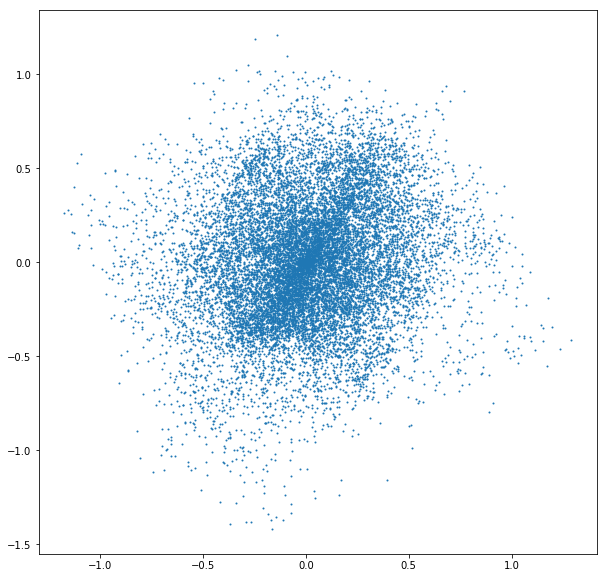

In [13]:
plt.plot(y[:,0], y[:,1],"o",markersize=1)
plt.show()

### Q: Voici la même chose mais construite avec les signaux issues des STFT. Que pouvez-vous observer ? 

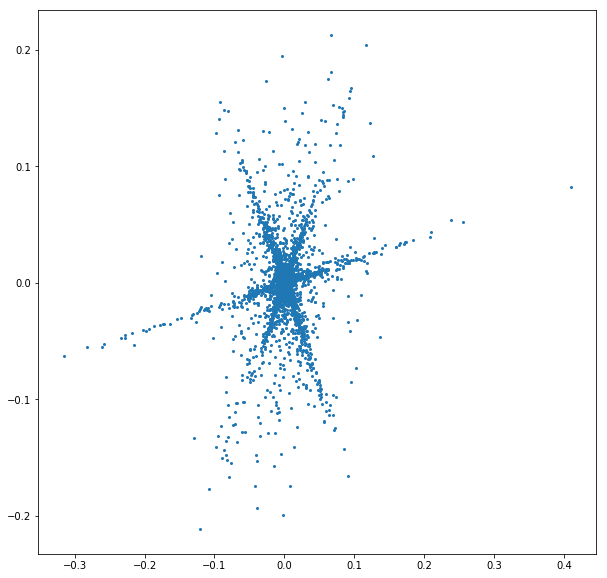

In [14]:
t,f,w0 = sig.stft(y[:,0])
t,f,w1 = sig.stft(y[:,1])

H = np.asarray([np.real(w0.flatten()),np.real(w1.flatten())]).transpose()
plt.figure(figsize = (10,10))
plt.plot(H[:,0],H[:,1],"o",markersize=2)

### Q: Pour chaque point dans la figure ci-dessus, calculer son angle (du vecteur qu'il forme avec 0 et l'axe des abscisse). Calculer et tracer ensuite la fonction de distribution des angle (on utilisera la fonction plt.hist, utilisez un grand nombre de "bins", typiquement quelques centaines). 

### Q: En sélectionnant les maxima de la fonction de distribution (tracée sur $[0,\pi]$) , proposer une estimation des angles.

In [16]:
### Écrivez votre code ici.

### Q: En utilisant la STFT des signaux, à chaque point dans le plan, calculer sa projection sur chaque direction estimée. On obtient alors un vecteur des 3 projections estimées.


In [17]:
### Écrivez votre code ici.

### Q: Pour chaque point fréquentiel, vous allez sélectionner la direction qui a la plus grande projection. Pour annuler un éventuel bruit résiduel, on utilise une fonction de thresholding pour mettre à 0 les points qui n'ont pas une magnitude suffisamment importante. Elle est écrite ci-dessous.

In [18]:
### Écrivez votre code ici.
#threshold = .005
#D = np.sqrt(np.sum(W**2, 0))
#I = I*(D > threshold)

### Q: Tracer les signaux retrouvés et leur STFT et comparer graphiquement aux signaux originaux. Estimer la performance en utilisant le Signal To Noise Ratio (SNR) qui est implémenté ci-dessous.

In [19]:
def snr(x, y):
    s =  np.linalg.norm(x - y)
    if s == 0:
        return "Equal inputs"
    return 20 * np.log10(np.linalg.norm(x) /s)

### Q: Écouter les signaux reconstruits et les comparer aux signaux originaux.

In [20]:
i = 0
from IPython.display import Audio
#Audio(X[i], rate = 16000)

In [21]:
i = 0
from IPython.display import Audio
#Audio(x[:,i], rate = 16000)

# 2. Le but de cette partie est d'explorer les implémentations d'un filtre FIR et d'un IIR.

## On trace ci-dessous un signal qui mixe des hautes et des basses fréquences.

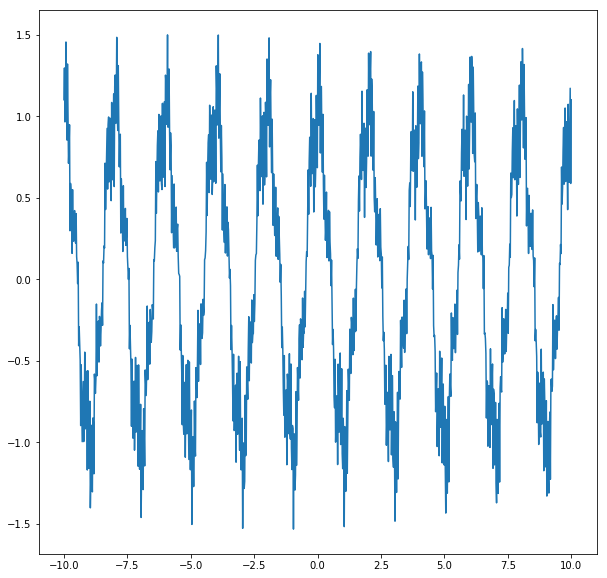

In [22]:
f = lambda t: np.cos(np.pi*t) + 0.2*np.sin(5*np.pi*t+0.1) + 0.2*np.sin(30*np.pi*t)  + 0.1*np.sin(32*np.pi*t+0.1) + 0.1*np.sin(47* np.pi*t+0.8)
t=np.linspace(-10,10,1000) 
signal=f(t)
plt.plot(t, signal)

## Q1. Implémenter un filtre passe-bas en utilisant la transformée de Fourier 1D:
### Calculer l'inverse de la FFT d'un filtre passe bas et le couper avec une fenêtre qui sera passée en argument de la fonction. Appliquer ensuite le filtre passe-bas par convolution, ou directement en fréquence avec la FFT et son inverse.


## Q2. En utilisant le code ci-dessous, implémenter un filtre à réponse impulsionnelle infinie défini par son numérateur qui sera une constante $b$ et son numérateur défini par $1-az^{-1}$. 
### Que pouvez-vous dire sur le paramètre $a$ pour que le filtre soit stable ?  
### Expérimentalement, faire varier les paramètres $a$ et $b$ et commenter. Peut-on obtenir un filtre passe-bas, passe-haut. Comment le justifier avec un argument théorique ?

In [23]:
def myIIR(x,a,b):
    ### a is the numerator
    ### b is the denominator
    assert(len(a)==len(b)),"a,b must have the same length"
    y = np.zeros_like(x)
    k = len(a)
    for i in range(len(a),len(x)):
        y[i] = np.sum(np.flipud(b)*y[i-k:i]) + np.sum(np.flipud(a) * x[i-k+1:i+1])
    return y

## Dans ce qui suit, on se donne un électrocardiogramme. On le trace en fonction du temps.

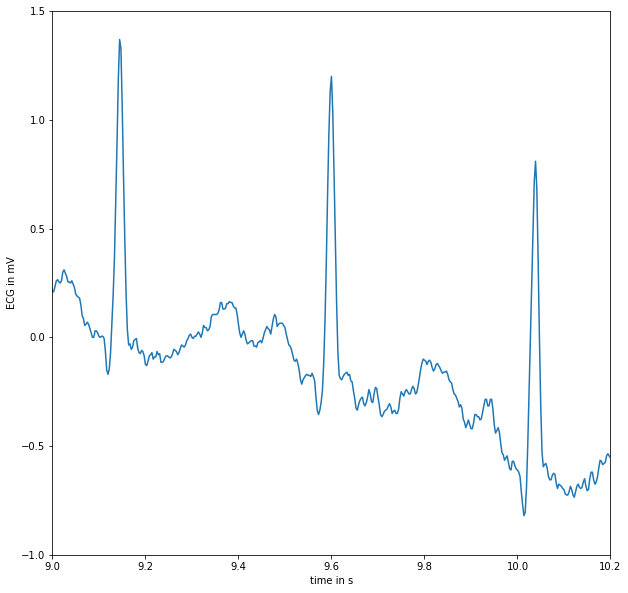

time min 0.0
time max 299.9972222222222


In [24]:
### load the data which is an electrocardiogram which is sampled at 360Hz
ecg = misc.electrocardiogram()
### Different plots.
fs = 360.0
### Since it is sampled at 360Hz, recall that Hz is the number of cycle per second, then the
### time is obtained as follows:
time = np.arange(ecg.size) / fs
### simple plot.
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(9, 10.2) # on affiche seulement une partie du signal
plt.ylim(-1, 1.5)
plt.show()
print("time min", time[0])
print("time max", time[-1])



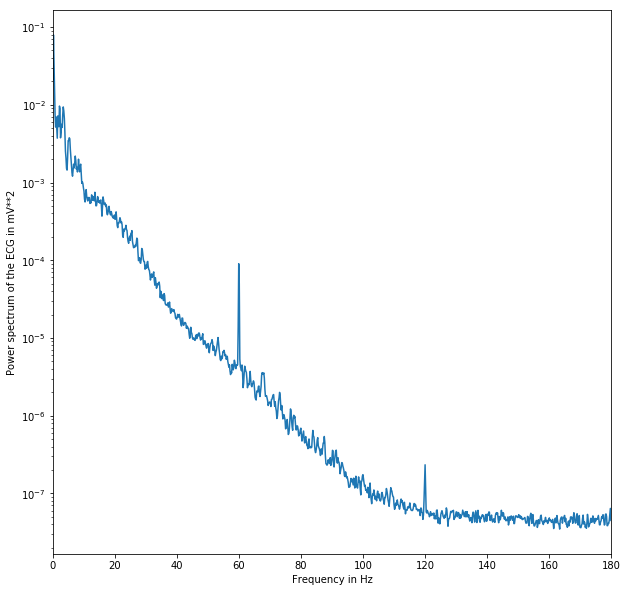

In [25]:
### Use the scipy function to get the power spectrum of the signal.
f, Pxx = sig.welch(ecg, fs=fs, nperseg=2048, scaling="spectrum")
plt.semilogy(f, Pxx)
plt.xlabel("Frequency in Hz")
plt.ylabel("Power spectrum of the ECG in mV**2")
plt.xlim(f[[0, -1]])
plt.show()

## Q3. Estimer le nombre de battements cardiaques dans l'électrocardiogramme, et l'intervalle de temps moyen entre deux battements cardiaque. Vous avez le choix de votre méthode. Une méthode possible consiste à utiliser un filtre passe-bas et extraire les maxima du signal filtré.